In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from scipy.stats import bernoulli 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=256, mask_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.mask_size = mask_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg" #".bmp" 
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 0)
        image = cv2.resize(image, (self.image_size, self.image_size))
        #image_LTP = np.ones([128,128,3])
        #for i in range(image.shape[2]):
         #   image_LTP[:,:,i] = LTP(image[:,:,i])
        #image = image_LTP
        
        mask = np.zeros((self.mask_size, self.mask_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.mask_size, self.mask_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
train_path = "dataset/ISICDATA/" #"dataset/PH2_Dataset_images/" #
epochs = 100
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 13

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
valid_ids

['ISIC_0000001',
 'ISIC_0000003',
 'ISIC_0000004',
 'ISIC_0000006',
 'ISIC_0000007',
 'ISIC_0000008',
 'ISIC_0000009',
 'ISIC_0000011',
 'ISIC_0000012',
 'ISIC_0000013',
 'ISIC_0000014',
 'ISIC_0000015',
 'ISIC_0000016']

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=256, mask_size=128)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
len(gen)

(8, 256, 256) (8, 128, 128, 1)


323

In [5]:
gentest = DataGen(valid_ids, train_path, batch_size=batch_size, image_size=256, mask_size=128)


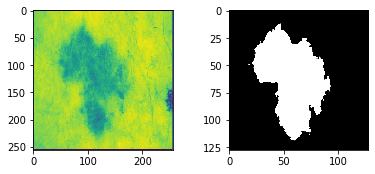

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
len(gen)

323

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvLBC(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, sparsity=0.5, padding=0):
        '''
        Description:
            -- Initialize anchor weights.
            -- Generate out_channels anchor weights with sparsity
        Parameters:
            -- sparsity: the sparsity of anchor weights
        '''
        super().__init__(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        anchor_weights = next(self.parameters())
        matrix_proba = torch.FloatTensor(anchor_weights.data.shape).fill_(0.5)
        binary_weights = torch.bernoulli(matrix_proba) * 2 - 1
        mask_inactive = torch.rand(matrix_proba.shape) > sparsity
        binary_weights.masked_fill_(mask_inactive, 0)
        anchor_weights.data = binary_weights
        anchor_weights.requires_grad = False


class LayerLBC(nn.Module):
    def __init__(self, in_channels, out_channels, num_weights=8, sparsity=0.5, kernel_size=3, padding=0):
        '''
        Description:
            -- Initialize a LBP Layer.
        Parameters:
            -- num_weights: the number of anchor_weights of each output channel
            -- sparsity: the sparsity of anchor weight
        '''
        super().__init__()
        # Generate out_channels*anchor_weights anchor weights 
        self.conv_lbp = ConvLBC(in_channels, out_channels*num_weights, kernel_size=kernel_size, sparsity=sparsity, padding=padding)
        # 1x1 convolution layer
        self.conv_1x1 = nn.Conv2d(num_weights, 1, kernel_size=1)
        self.num_weights = num_weights
        self.output_channel = out_channels

    def forward(self, x):
        x = F.relu(self.conv_lbp(x))
        x = x.view(x.size(0)*self.output_channel, self.num_weights, x.size(2), x.size(3))
        x = self.conv_1x1(x)
        x = x.view(x.size(0)//self.output_channel, self.output_channel, x.size(2), x.size(3))
        return x
    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        #self.conv2 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.convv = double_conv(in_ch, out_ch)
        self.up_conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        #self.conv = double_conv(in_ch, out_ch)
        self.conv = DoubleConv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        #x1 = self.convv(x1)
        x1 = self.up_conv(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class last_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(last_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        return x

class SimpleNetLBC(nn.Module):
    '''
    Description:
        -- A simple model based on LBCNN
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            LayerLBC(in_channels=1, out_channels=16, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            LayerLBC(in_channels=16, out_channels=32, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            LayerLBC(in_channels=32, out_channels=64, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv4 = nn.Sequential(
            LayerLBC(in_channels=64, out_channels=128, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv5 = nn.Sequential(
            LayerLBC(in_channels=128, out_channels=256, num_weights=8, sparsity= 0.9, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.up1 = up(256, 128) # 8 ----> 16
        self.up2 = up(128, 64)  # 16 ---> 32
        self.up3 = up(64, 32)   # 32 ---> 64
        self.up4 = up(32, 16)   # 64 ---> 128
        #self.otc = double_conv(16,1)
        #self.up5 = up(16, 1)    # 128 ---> 
        #self.outc = OutConv(8, 1)
        self.out = last_conv(16,1)

    def forward(self, x):
        #x0 = self.conv5(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #x = self.up5(x, x1)
        #x = self.up1(x2, x1)
        logits = self.out(x) #self.outc(x)
        return logits
    #def forward(self, x):
     #   out = self.conv1(x)
      #  out = self.conv2(out)
       # out = out.view(x.shape[0], -1)
        #out = self.fc_layers(out)
        #return out


In [9]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    
    y_true = y_true.view([y_true.shape[0], 128, 128,1])
    y_pred = y_pred.view([y_pred.shape[0], 128, 128, 1])
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    
    with tf.Session() as sess:
        iou = sess.run(iou)
        
    return iou

Using TensorFlow backend.


In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    
    y_true = y_true.view([y_true.shape[0], 128, 128,1])
    y_pred = y_pred.view([y_pred.shape[0], 128, 128, 1])
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    
    with tf.Session() as sess:
        dice = sess.run(dice)
    
    return dice

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model =  SimpleNetLBC()
criterion = torch.nn.BCELoss() #nn.BCEWithLogitsLoss()  #torch.nn.BCELoss()#(size_average=True)   
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #torch.optim.Adagrad(model.parameters(), lr=0.001) 
num_epochs = 15

accuracy_epoch = []
loss_epoch = []
jaccard_epoch = []
dice_epoch = []
acc_output =[]
loss_epoch_test = []
accuracy_epoch_test = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0
        total_train = 0
        correct_train = 0
        loss_values = []     
        avg_accuracy =[]
        avg_jaccard = []
        avg_dice = []
        running_loss = 0.0
        
        testing_loss = 0.0
        avg_accuracy_test = []
        loss_values_test = []
        #Epoch_loss = 0.0
        #Epoch_accuracy = 0.0
        for i, data in enumerate(gen, 0):
            
            # get the inputs
            t_image, mask = gen.__getitem__(0)
            t_image, mask = torch.Tensor(t_image), torch.Tensor(mask)
            t_image = t_image.view([t_image.shape[0], 1 , t_image.shape[1], t_image.shape[2]])
            mask = mask.view([mask.shape[0], 1 , mask.shape[1], mask.shape[2]])
            t_image, mask = Variable(t_image.float()), Variable(mask.float()) #Variable(t_image.to(device)), Variable(mask.to(device))
        

            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(t_image) # forward
            outputs = torch.sigmoid(output)
            loss = criterion(outputs, mask) # calculate the loss
            loss.backward() # back propagation
            optimizer.step() # update gradients
            running_loss += loss.item()
            ##mask = torch.tensor(mask, dtype=torch.long, device=device)
            
            #running_loss += loss.item()
            
            acc_output = (outputs>0.5).float()
            running_loss =+ loss.item() * t_image.size(0)
            correct = (acc_output == mask).float().sum()
            x = outputs.shape[0]*128*128
            accuracy = correct/x
            loss_values.append(running_loss)

            
            #Accuracy
           
            avg_accuracy.append(accuracy)
            #print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.item(), accuracy ))
            
            # Jaccard Accuracy 
            Jaccard = iou_coef(outputs, mask, smooth=1)
            avg_jaccard.append(Jaccard)
                        
            # Dice Accuracy 
            Dice = dice_coef(outputs, mask, smooth=1)
            avg_dice.append(Dice)
            
            model.eval()
            with torch.no_grad():
                for inputs, labels in gentest:
                    inputs, labels = gentest.__getitem__(0)
                    inputs, labels = torch.Tensor(inputs), torch.Tensor(labels)
                    inputs = inputs.view([inputs.shape[0], 1 , inputs.shape[1], inputs.shape[2]])
                    labels = labels.view([labels.shape[0], 1 , labels.shape[1], labels.shape[2]])
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    logps = torch.sigmoid(logps)
                    batch_loss = criterion(logps, labels)
                    testing_loss += batch_loss.item()
                    
                    running_losse =+ batch_loss.item() * inputs.size(0)
                    loss_values_test.append(running_losse)

            
            #Accuracy
                    acc_test = (logps>0.5).float()
                    correct_test = (acc_test == labels).float().sum()
                    xx = inputs.shape[0]*128*128
                    accuracy_test = correct_test/xx
                    avg_accuracy_test.append(accuracy_test)
            model.train()
                    
            
        # Loss & Accuraccy in each epoch 
        Epoch_loss_test = sum(loss_values_test) / len(loss_values_test)
        Epoch_accuracy_test = sum(avg_accuracy_test) / len(avg_accuracy_test)
        loss_epoch_test.append(Epoch_loss_test)
        accuracy_epoch_test.append(Epoch_accuracy_test)
             
        
            #print("Epoch {}/{}, Jaccard Coef: {:.3f}, Dice: {:.3f}".format(epoch+1, num_epochs, Jaccard, Dice))   
        
        ##Dice & Jaccard in each epoah 
        Epoch_jaccard = sum(avg_jaccard)/len(avg_jaccard)
        Epoch_dice = sum(avg_dice) / len(avg_dice)
        jaccard_epoch.append(Epoch_jaccard)
        dice_epoch.append(Epoch_dice)
        
        print("Epoch {}/{}, Avg_Jaccard: {:.3f}, Avg_Dice: {:.3f}".format(epoch+1, num_epochs, Epoch_jaccard, Epoch_dice))
        
        ## Loss & Accuraccy in each epoch 
        Epoch_loss = sum(loss_values) / len(loss_values)
        Epoch_accuracy = sum(avg_accuracy) / len(avg_accuracy)
        loss_epoch.append(Epoch_loss)
        accuracy_epoch.append(Epoch_accuracy)
        
        
        print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(epoch+1, num_epochs, Epoch_loss, Epoch_accuracy))

        print("Epoch {}/{}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(epoch+1, num_epochs, Epoch_loss_test, Epoch_accuracy_test))
print('Finished Training Trainset')
        #plt.plot(loss_values)
        #plt.plot(avg_accuracy)
#plt.plot(accuracy_epoch)
#plt.plot(loss_epoch)
            
            

Epoch 1/15, Avg_Jaccard: 0.447, Avg_Dice: 0.606
Epoch 1/15, Training Loss: 2.481, Training Accuracy: 0.930
Epoch 1/15, Testing Loss: 0.357, Testing Accuracy: 0.942
Epoch 2/15, Avg_Jaccard: 0.764, Avg_Dice: 0.864
Epoch 2/15, Training Loss: 0.307, Training Accuracy: 0.984
Epoch 2/15, Testing Loss: 0.233, Testing Accuracy: 0.917
Epoch 3/15, Avg_Jaccard: 0.884, Avg_Dice: 0.938
Epoch 3/15, Training Loss: 0.135, Training Accuracy: 0.992
Epoch 3/15, Testing Loss: 0.091, Testing Accuracy: 0.971
Epoch 4/15, Avg_Jaccard: 0.922, Avg_Dice: 0.959
Epoch 4/15, Training Loss: 0.090, Training Accuracy: 0.993
Epoch 4/15, Testing Loss: 0.063, Testing Accuracy: 0.980


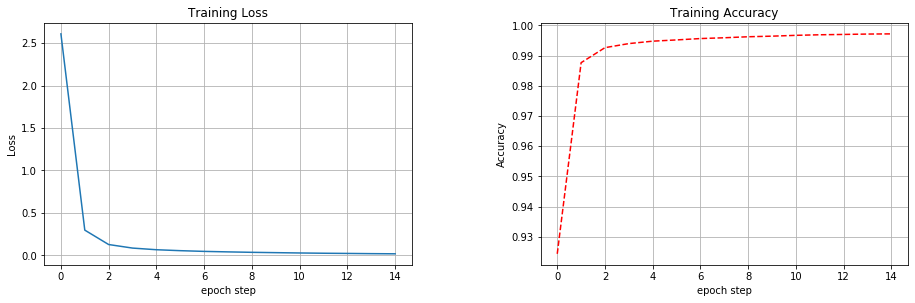

In [35]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import matplotlib.pyplot as plt
plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch)
#plt.plot(loss_epoch_test)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Training Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Training Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()

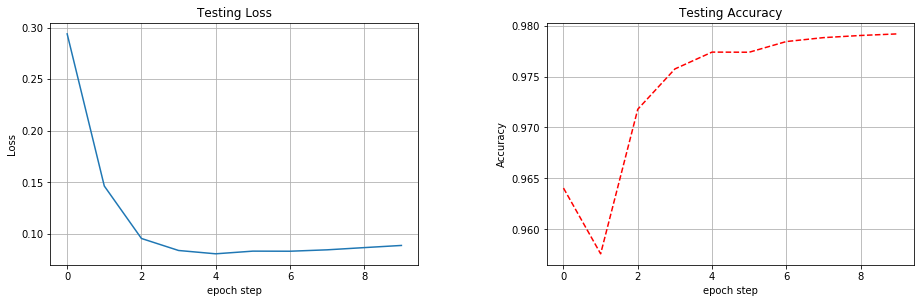

In [17]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

plt.figure()

# loss
plt.subplot(121)
plt.plot(loss_epoch_test)
#plt.plot(loss_epoch_test)
plt.ylabel('Loss')
plt.xlabel('epoch step')
plt.title('Testing Loss')
plt.grid(True)


# Accuracy 
plt.subplot(122)
plt.plot(accuracy_epoch_test, 'r--')
plt.ylabel('Accuracy')
plt.xlabel('epoch step')
plt.title('Testing Accuracy')
plt.grid(True)

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.00001, right=2, hspace=0.55, wspace=0.35)

plt.show()

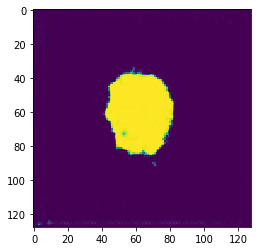

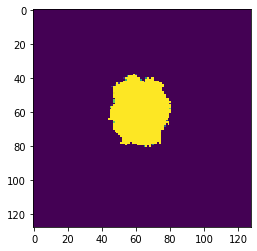

In [21]:
a = logps[0]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

aa = labels[0]
b = aa.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

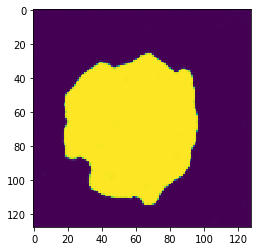

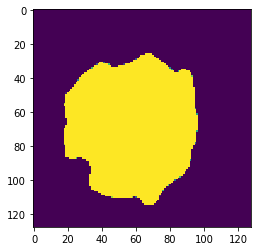

In [22]:
a = outputs[2]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()

a = mask[2]
b = a.view((128,128))
b.shape
b = (Variable(b).data).cpu().numpy()
b.shape
plt.imshow(b)
plt.show()